# GMM Build

## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random as r

from scipy.spatial import distance
from statistics import mean
from math import exp, pi, sqrt, log

from random import sample, uniform
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

import time
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score

## Optimization Problem and Solution Approach

GMMs perform soft clustering based on a generative assumption, whereby all observations have been generated by a cluster who's generative function follows some probabilistic distribution. Specifically, he model assumes that the underlying distribution of each clusters $k$ is a multivariate Gaussian with mean $\mu_k$ and covariance $COV_k$.

Based on these assumptions, GMMs calculate the probability that a given observation $\vec x$ with $p$ features is generated by (belongs to) a cluster using the definition of the probability function of a multivariate Gaussian distribution.

$$
p(x|\mu, COV) = \frac{1}{(2\pi)^{\frac{p}{2}}|COV|^{\frac{1}{2}}}\exp\bigg(-\frac{1}{2}(x-\mu)^T COV^{-1}(x-\mu) \bigg)
$$

Using this equation, the GMM performs soft clustering based on the relative probability of every observation in the data set belonging to each cluster. However, as this is an unsupervised clustering task the cluster means and covariances are unknown and need to be estimated based on the input observations and number of clusters. 

As such, the latent variables of the model are the cluster means $\mu_k$ and cluster covariances $COV_k$. In order to complete the clustering task, the GMM needs to first estimate these variables to maximize the likelihood that all $n$ observations in the data set were generated on of $K$ clusters. The optimization problem can expressed as:

$$
maximize \bigg(\prod_{i=1}^n \prod_{k=1}^{K} p(\vec x_i| \vec \mu_k, COV_k) \bigg)
$$

A popular approach to solving this optimization problem is the expectation-maximization (EM) algorithm. EM is an iterative two step process that begins by calculating the Expectation $z^i_k$ of a observation $x_i$ belonging to cluster $k$, defined as:

$$
z^i_k = \frac{p(\vec x_i| \vec \mu_k, COV_k)}{\sum_{k=1}^{K} p(\vec x_i| \vec \mu_k, COV_k) }
$$

The expectation calculation adjusts the likelihood terms across all observation-cluster combinations such that the expectation that each observation is generated by any one of the k clusters is 1. This is key for the next step of the process, Maximization, where the assumed means and covariances are updated based on the expectation values.

$$
\vec \mu_k = \frac{1}{z_k} \sum_{i=1}^{n} z_i^k \vec x_i
$$

$$
COV_k = \frac{1}{z_k} \sum_{i=1}^n z_k^i (\vec x_i - \vec \mu_k)(\vec x_i - \vec \mu_k)^T
$$

Expectations are used to weight the contribution of each observation when calculating the cluster mean and covariance updates. The expectation step is then repeated based on the new values and the process iterates until the values converge.

## Implementation

In the following implementation we initialize the cluster means using a KMeans algorithm to improve model sability and accelerate convergence time. The initialized cluster covariances are assumed to be equal to the data set covariance.

In [16]:
# Define basic KMeans function to initialize GMM clusters

def fit_kmeans(X, k):
    
    X = pd.DataFrame(X)
    
    obs = len(X)
    clus_lab = list(range(k))
    
    clus_0 = r.choices(population=clus_lab  ,k=obs)
    clus_1 = []
    
    means_0 = {}
    
    for lab in clus_lab:
        means_0[lab] = X[pd.Series(clus_0)==lab].mean().values
    
    iteration = 0
    while True:
        iteration+=1
        
        clus_means = np.array(list(means_0.values()))
        clus_labels = np.array(clus_0)
        new_colors = clus_means[clus_labels]
        
        clus_1 = []
        
        for i in range(obs):
            observation = X.iloc[i].values
            min_dist = distance.euclidean(observation, means_0[lab])
            
            for lab in clus_lab:
                dist = distance.euclidean(observation, means_0[lab])
                if dist < min_dist or lab == 0:
                    min_dist = dist
                    cluster = lab
            
            clus_1.append(cluster)
                    
        for lab in clus_lab:
            means_0[lab] = X[pd.Series(clus_1)==lab].mean().fillna(0).values
            
        if clus_0 == clus_1:
            break
        
        clus_0 = clus_1
    
    return clus_0, means_0

In [19]:
# calculate observation-cluster probability 
z_i_k = lambda x_i, u_k, cov_k : exp(-0.5*(x_i-u_k) @ np.linalg.inv(cov_k) @ (x_i-u_k).T)/((2*pi)**(len(x_i)/2)*sqrt(np.linalg.det(cov_k)))

# calculate cluster mean based on observtions and cluster-observation probabilities
clus_mean = lambda X, z_k: 1/z_k.sum()*sum([z_k[i]*X[i] for i in range(len(z_k))])

# calculate covarience using cluster mean 
clus_cov = lambda X, u_k, z_k: 1/z_k.sum()*sum([z_k[i]*(X[i]-u_k).T@(X[i]-u_k) for i in range(len(z_k))])

In [20]:
# Function to calculate observation expecations based on cluster distributions
def gmm_proba(X, clus_means, clus_covs):
    epsilon = 0.0000001
    k = clus_means.shape[0]
    obs = X.shape[0]
    z = np.empty((k, obs))
    
    for cluster in range(k):
        for observation in range(obs):
            # Calculate new expectation value
            z[cluster, observation] = z_i_k(
                X[observation], 
                clus_means[cluster], 
                clus_covs[cluster]
            )
            + epsilon # avoid divide by 0 error
            
    return normalize(z, norm='l1', axis=0)

In [21]:
# Function to assign observations to clusters based on cluster distributions
def gmm_labels(X, clus_means, clus_covs):
    prob = gmm_proba(X, clus_means, clus_covs)
    return prob.argmax(axis=0)

In [22]:
def gmm_fit(X, k, threshold = 0.0005):
    
    obs = X.shape[0] # number of observations
    p = X.shape[1] # number of parameters
    
    _, clus_means = fit_kmeans(X, k)
    clus_means = np.matrix(
        pd.DataFrame(clus_means).T.values.reshape(k, p)
    )
    
    # initialize cluster cov based on full dataset and initialized means
    x_cov = pd.DataFrame(X).cov().values
    clus_covs = [x_cov for cluster in range(k)]
    
    # kick-off iterative expectation_maximiztion step
    
    change = True # iniialize change flag to enter loop
    i = 0
    
    norm_z = np.empty((k, obs))
    
    while True:
        means_int = clus_means.copy()
        covs_int = clus_covs.copy()
        
        # Expectation step
        new_norm_z = gmm_proba(X, clus_means, clus_covs)
        diff = norm_z-new_norm_z
        
        l2_diff = np.einsum('ij,ji->i', diff,diff.T).sum()/diff.size
        
        if l2_diff < threshold:
            break
        
        norm_z = new_norm_z
        
        
        # Maximization step
        for cluster in range(k):              
            clus_means[cluster] = clus_mean(
                X, norm_z[cluster]
            ) # update cluster mean
            clus_covs[cluster] = clus_cov(
                X, clus_means[cluster], norm_z[cluster]
            ) # update cluster cov
        
    return clus_means, clus_covs

## PoC Check

In [23]:
# Standardize input data to improve model stability
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('clustering_gmm.csv')
scaler = MinMaxScaler()

X = scaler.fit_transform(data)

In [24]:
clus_means, clus_covs = gmm_fit(X, 4)

In [25]:
clus_labs = gmm_labels(X, clus_means, clus_covs)

In [26]:
frame = pd.DataFrame(data)
frame['cluster'] = clus_labs
frame.columns = ['Weight', 'Height', 'cluster']

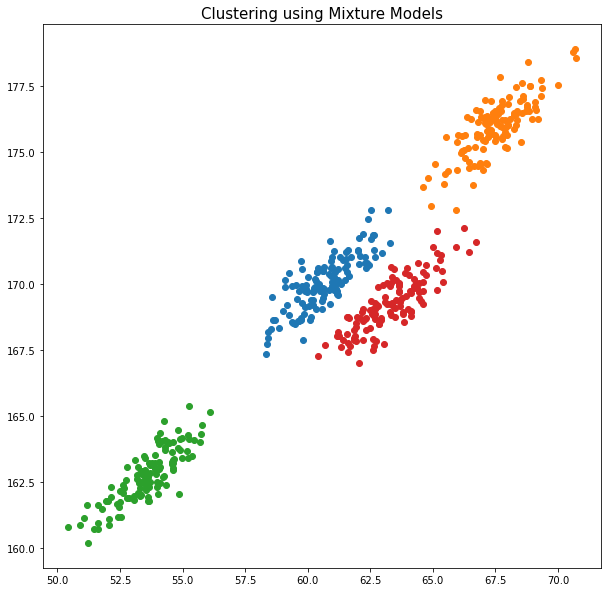

In [27]:
# Visualize the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for k in range(0,4):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["Weight"],data["Height"],cmap = 'viridis')
plt.title('Clustering using Mixture Models', fontsize = 15)
plt.show()

## Black-Box Comparison

In [28]:
def perf_test(n= 500, feats= 2, k= 2, gmm_threshold = 0.0005):
    res =  {'model': [], 'n': [], 'features': [], 'clusters': [],
            'time': [], 'log_threshold': [], 'silohuette_score': [],
            'random_index': []}
    
    for i in range(5):
        X, y = make_blobs(n_samples= n,
                          n_features = feats, 
                          centers= k, 
                          random_state= i)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

        gmm = GaussianMixture(n_components=k, random_state=0)

        # black box
        start = time.time()
        model = gmm.fit(X)
        end = time.time()
        
        bb_lab = model.predict(X)
        
        res['model'].append('Black-Box Algo')
        res['n'].append(n)
        res['features'].append(feats)
        res['clusters'].append(k)
        res['time'].append(end-start)
        res['silohuette_score'].append(
            silhouette_score(X, bb_lab)
        )
        res['random_index'].append(rand_score(y, bb_lab))
        res['log_threshold'].append(log(gmm_threshold))

        # GMM
        start = time.time()
        means, covs = gmm_fit(X, k, threshold = gmm_threshold)
        end = time.time()
        
        gmm_lab = gmm_labels(X, means, covs)
        res['model'].append('GMM')
        res['n'].append(n)
        res['features'].append(feats)
        res['clusters'].append(k)
        res['time'].append(end-start)
        res['silohuette_score'].append(
            silhouette_score(X, gmm_lab)
        )
        res['random_index'].append(rand_score(y, gmm_lab))
        res['log_threshold'].append(log(gmm_threshold))
    
    return pd.DataFrame(res)

### Varying observation counts

In [47]:
n_obs = range(100, 1000, 100)

results_1 = pd.DataFrame()

for obs in n_obs:
    results_1 = pd.concat([results_1, perf_test(n=obs)])

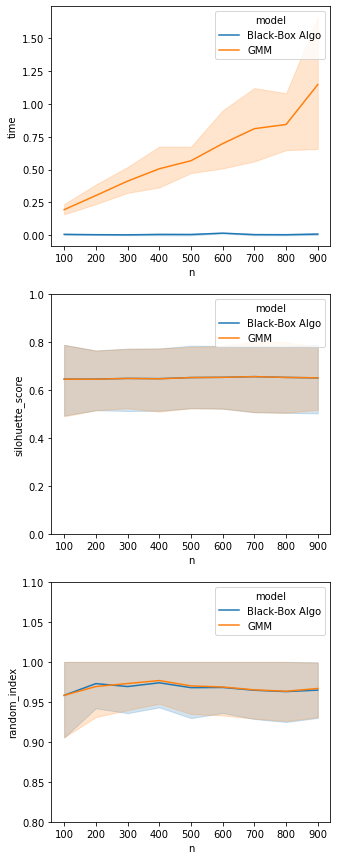

In [54]:
fig, axes = plt.subplots(3, figsize = (5,15))
sns.lineplot(data= results_1, x='n', y='time', hue='model', ax=axes[0])
sns.lineplot(data= results_1, x='n', y='silohuette_score', hue='model', ax = axes[1])
sns.lineplot(data= results_1, x='n', y='random_index', hue='model', ax = axes[2])
axes[1].set_ylim((0,1))
axes[2].set_ylim((0.8,1.1))
fig.savefig('over_n.png')

### Varying feature counts

In [55]:
n_features = range(2, 36, 3)

results_2 = pd.DataFrame()

for feat in n_features:
    results_2 = pd.concat([results_2, perf_test(feats=feat)])

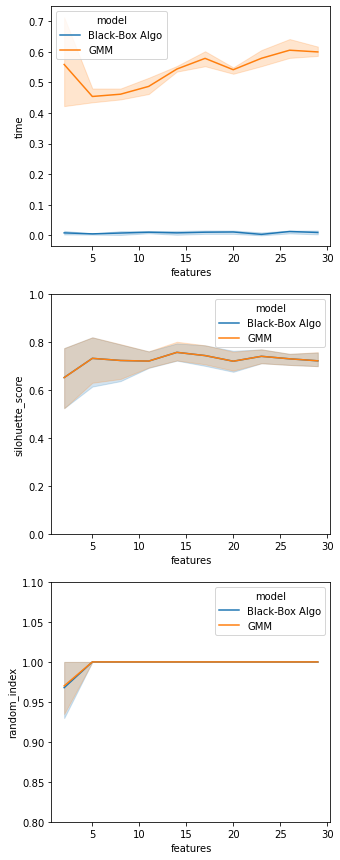

In [50]:
fig, axes = plt.subplots(3, figsize = (5,15))
sns.lineplot(data= results_2, x='features', y='time', hue='model', ax=axes[0])
sns.lineplot(data= results_2, x='features', y='silohuette_score', hue='model', ax = axes[1])
sns.lineplot(data= results_2, x='features', y='random_index', hue='model', ax = axes[2])
axes[1].set_ylim((0,1))
axes[2].set_ylim((0.8,1.1))
fig.savefig('over_feat.png')

### Varying cluster counts

In [51]:
n_clusters = range(2, 22, 2)

results_3 = pd.DataFrame()

for cluster in n_clusters:
    results_3 = pd.concat([results_3, perf_test(k=cluster, n=1000)])

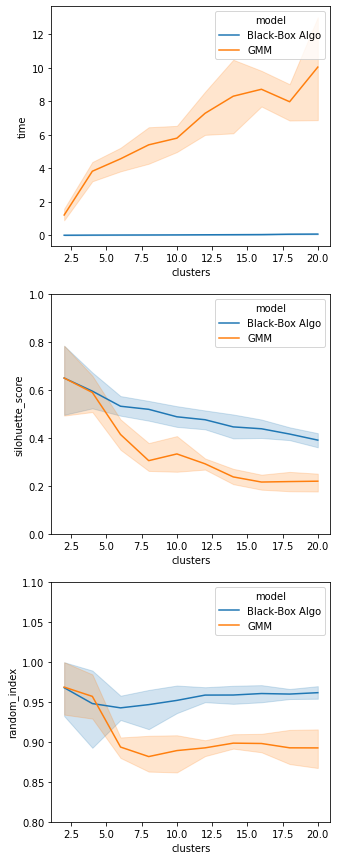

In [52]:
fig, axes = plt.subplots(3, figsize = (5,15))
sns.lineplot(data= results_3, x='clusters', y='time', hue='model', ax=axes[0])
sns.lineplot(data= results_3, x='clusters', y='silohuette_score', hue='model', ax = axes[1])
sns.lineplot(data= results_3, x='clusters', y='random_index', hue='model', ax = axes[2])
axes[1].set_ylim((0,1))
axes[2].set_ylim((0.8,1.1))
fig.savefig('over_clust.png')